In [1]:
using HydroTools, Plots, Test

In [2]:
n = 150
dz = ones(n)
z, z₊ₕ, dz₊ₕ = soil_depth_init(dz)

soil_texture = 1
param = (soil_texture=1,
Θ_res=0.075, Θ_sat=0.287,
α=0.027, n=3.96, m=1, K_sat=34 / 3600)

Θ = fill(0.1, n)
ψ = matric_potential(Θ, param; method="van_Genuchten")

Θ0 = 0.267
ψ0 = matric_potential(Θ0, param; method="van_Genuchten")

dt = 5
ntim = 0.8 * 3600 / dt

(;Θ, ψ, ψ0, dz, dt, param)

(Θ = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ψ = [-61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255  …  -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255, -61.562813229655255], ψ0 = -20.921265200082487, dz = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dt = 5, param = (soil_texture = 1, Θ_res = 0.075, Θ_sat = 0.287, α = 0.027, n = 3.96, m = 1, K_sat = 0.009444444444444445))

In [15]:
@time begin
  # % --- Initialize accumulators for water balance check
  sum_in = 0
  sum_out = 0
  sum_store = 0

  # --- Time stepping loop: NTIM iterations with a time step of DT seconds
  @time for itim = 1:ntim
    hour = itim * (dt / 86400 * 24)
    # @printf("hour = %8.3f\n", hour)
    # Calculate soil moisture
    Q0, QN, dθ, err = soil_moisture!(Θ, ψ, ψ0, dz, dt, param)
    
    # % Sum fluxes for relative mass balance error
    sum_in += abs(Q0) * dt
    sum_out += abs(QN) * dt
    sum_store += dθ
  end

  # @test sum_in == 11.810243822643141
  # @test sum_out == 0.10508872215771699
  # @test sum_store == 11.704825251924781
end

  0.049212 seconds (27.71 k allocations: 14.723 MiB, 31.21% gc time)
  0.050888 seconds (27.74 k allocations: 14.725 MiB, 30.19% gc time)


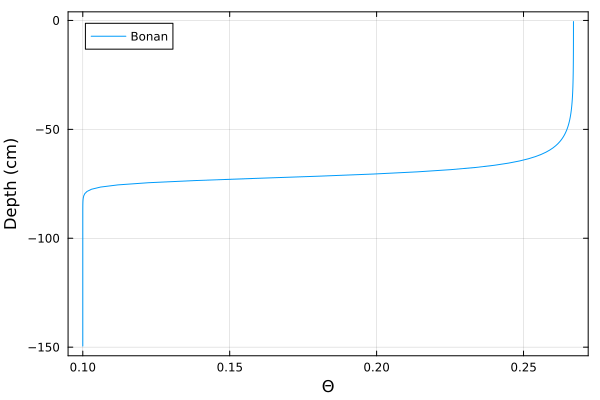

In [11]:
gr(framestyle=:box)
plot(Θ, z; label="Bonan", xlabel="Θ", ylabel="Depth (cm)")

In [14]:
using JLD2
jldsave("data/output_bonan.jld2"; θ=Θ, ψ)